In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from RoomObjects import Room, Object

In [2]:
def add_bed(room, disp = False):

    """ Add a bed to the room. The bed is intially placed in the centre of the room. 
        It cannot rotate the bed, but the position will be optimized. 
        If there is already a bed in the room, this function will not add another one.
    
        Parameters:
        room (Room): Room object to add the bed to.
        disp (bool): If True, the room will be displayed with the new bed.
    """

    bed = room.find('bed')
    if bed == None:
        print("There is no bed in this room. Adding one now.")
        room.moving_objects += [Object('bed', room.center, 1.37, 1.91)]
        bed = room.find('bed')
    
    doors = room.find_all('door')
    windows = room.find_all('window')

    W, L = room.width, room.length
    w = bed.width
    l = bed.length
    nw = 0.9 # nightstand width

    def objective(position):

        x, y = position

        ## Constraint: Bed against wall
        wall_distances = [x - w/2, W - (x + w/2), y - l/2, L - (y + l/2)]
        d_wall = np.min(wall_distances)

        ## Constraints: Bed away from doors and windows
        d_door = 0
        d_window = 0
        for door in doors:
            d_door += np.sqrt((x - door.position[0])**2 + (y - door.position[1])**2)
        
        for window in windows:
            d_window += np.sqrt((x - window.position[0])**2 + (y - window.position[1])**2)

        ## Constraint: Bed centered on a wall 
        d_north = np.sqrt((x - W/2)**2 + (y - l/2)**2)
        d_south = np.sqrt((x - W/2)**2 + (y - (L - l/2))**2)
        d_east = np.sqrt((x - (W - w/2))**2 + (y - L/2)**2)
        d_west = np.sqrt((x - w/2)**2 + (y - L/2)**2)

        ## Constraint: Enough Space for Nightstands
        c_left = 100 
        c_right = 100 
        for door in doors:

            if (door.position[0] + door.width/2) < x:
                left_val = np.maximum(x - w/2 - (door.position[0] + door.width/2), 0.0)
            else:
                left_val = c_left
            if (door.position[0] - door.width/2) > x:
                right_val = np.maximum((door.position[0] - door.width/2) - (x + w/2), 0.0)
            else: 
                right_val = c_right

            if left_val < c_left:
                c_left = left_val
            if right_val < c_right:
                c_right = right_val

        out = d_wall + (2/d_door) + (2/d_window) + np.min([d_north, d_south, d_east, d_west]) + np.maximum(0, nw - c_left) + np.maximum(0, nw - c_right)
        out += room.boundary_constraint(x, y, bed, weight = 100) + room.intersection_constraint(x, y, bed, weight = 5)
        
        return out
        
    res = minimize(objective, bed.position, method='Nelder-Mead')
    bed.position = res.x

    if disp:
        draw_room(room)

    return

def add_nightstand(room, disp = False):

    """ Add a nightstand to the room. The nightstand is initially placed in the centre of the room.
        If there are already 2 nightstands in the room, the function will not add another one. 
    
        Parameters:
        room (Room): Room object to add the nightstand to.
        disp (bool): If True, the room will be displayed with the new nightstand.
    """

    bed = room.find('bed')
    if bed == None: 
        print("There is no bed in this room. You should add a bed before adding nightstands.")
        return
    
    counter = room.count('nightstand')
    if counter >= 2:
        print("There are enough nightstands in this room. ")
        return
    
    elif counter == 1:
        print("Adding a second nightstand.")
        nightstand1 = room.find('nightstand')
        nightstand = Object('nightstand', room.center, 0.5, 0.5)
        room.moving_objects += [nightstand]

    elif counter == 0:
        print("There are no nightstands in this room. Adding one now.")
        nightstand = Object('nightstand', room.center, 0.5, 0.5)
        room.moving_objects += [nightstand]
    
    def objective(position):

        x, y = position
        w, l = nightstand.width, nightstand.length
        W, L = room.width, room.length

        ## Constraint: Nightstand near head of bed
        d_bed = np.sqrt((x - bed.position[0])**2 + (y - bed.position[1] - bed.length/2)**2)

        ## Constraint: Nightstand near wall   
        wall_distances = np.array([x - w/2, W - (x + w/2), y - l/2, L - (y + l/2)])
        d_wall = np.min(wall_distances**2)

        out = room.boundary_constraint(x, y, nightstand, weight = 50) + room.intersection_constraint(x, y, nightstand, weight = 3) + d_bed + d_wall

        # If second nighstand, add a penalty for lack of symmetry 
        if counter == 1:
            out += 10*(x - (2*bed.position[0] - nightstand1.position[0]))**2 + (y - nightstand1.position[1])**2

        return out
    
    res = minimize(objective, nightstand.position, method='Nelder-Mead')
    nightstand.position = res.x
    
    if disp:
        draw_room(room)

    return


def add_wardrobe(room, disp = False):

    """ Add a wardrobe to the room. The wardrobe is initially placed in the centre of the room.
        
        Parameters:
        room (Room): Room object to add the wardrobe to.
        disp (bool): If True, the room will be displayed with the new wardrobe.

    """
    
    windows = room.find_all('window')
    doors = room.find_all('door')

    wardrobe = room.find('wardrobe')
    if wardrobe == None:
        print("Adding a wardrobe.")
        wardrobe = Object('wardrobe', room.center, 0.6, 0.9)
        room.moving_objects += [wardrobe]
    
    def objective(position):

        x, y = position
        w, l = wardrobe.width, wardrobe.length
        W, L = room.width, room.length

        out = 0

        ## Constraint: In room boundaries
        out += room.boundary_constraint(x, y, wardrobe, weight = 50)

        ## Constraint: No intersection with other objects
        out += room.intersection_constraint(x, y, wardrobe, weight = 5)

        ## Constraint: Wardrobe near wall
        wall_distances = np.array([x - w/2, W - (x + w/2), y - l/2, L - (y + l/2)])
        d_wall = np.min(wall_distances**2)
        out += d_wall

        ## Constraint: Avoid Windows + Doors
        d_door = 0
        d_window = 0
        for door in doors:
            d_door += np.sqrt((x - door.position[0])**2 + (y - door.position[1])**2)
        
        for window in windows:
            d_window += np.sqrt((x - window.position[0])**2 + (y - window.position[1])**2)
        
        if len(doors) > 0:
            d_door = 1/d_door
        if len(windows) > 0:
            d_window = 1/d_window

        out += d_door + d_window

        ## Constraint: Room Balance
        out += room.balance_constraint(x, y, wardrobe, weight = 2)

        return out
    
    res = minimize(objective, wardrobe.position, method='Nelder-Mead')
    wardrobe.position = res.x
    if disp:
        draw_room(room)

    return
    

There is no bed in this room. Adding one now.
There are no nightstands in this room. Adding one now.
Adding a second nightstand.
Adding a wardrobe.


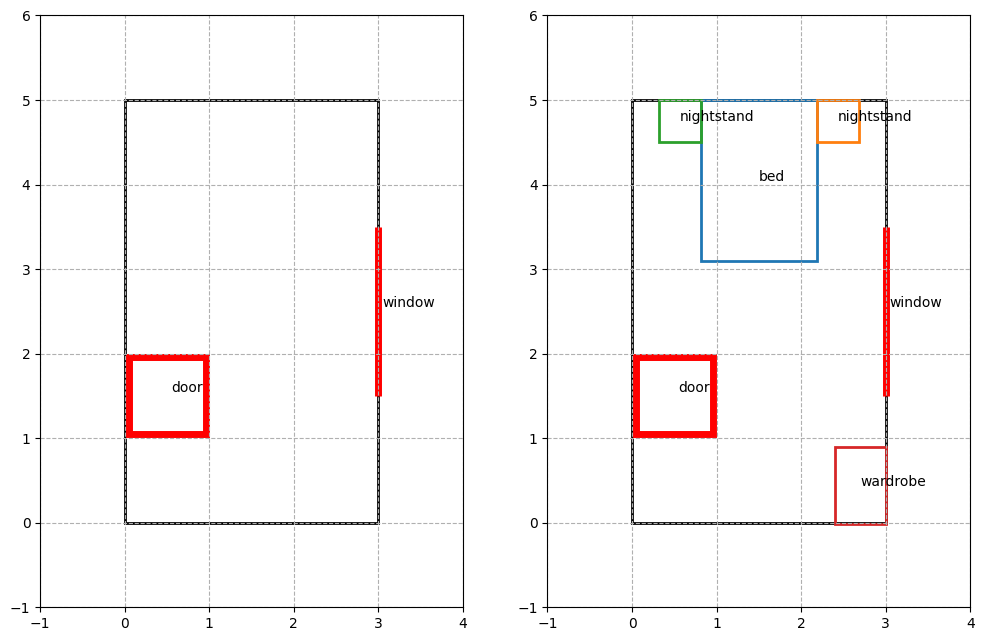

In [3]:
room = Room(3, 5)
room.fixed_objects = [Object('door', (0.5, 1.5), 0.91, 0.91), Object('window', (3, 2.5), 0, 2)]
room.add([add_bed, add_nightstand, add_nightstand, add_wardrobe])

There is no bed in this room. Adding one now.
There are no nightstands in this room. Adding one now.
Adding a second nightstand.
Adding a wardrobe.


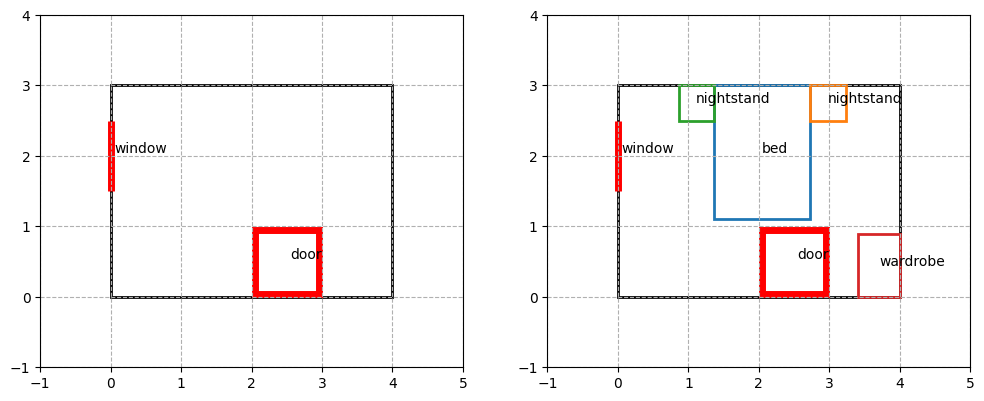

In [4]:
room = Room(4, 3)
room.fixed_objects = [Object('door', (2.5, 0.5), 0.91, 0.91),  Object('window', (0, 2), 0, 1)]

room.add([add_bed, add_nightstand, add_nightstand, add_wardrobe])